In [3]:
#using just the yelp dataset for training we were capped at out 80% accuracy. In this file we will combine all the
#datasets into a train/test split using out best hypter peramters found and just see what happens

In [1]:
import pandas as pd 
import numpy as np
import util
from keras.models import Sequential
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.layers import Dropout

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [2]:
df = util.get_full_data_frame()
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


In [3]:
sentences = df['sentence'].values
y = df['label'].values

sentences_train,sentences_test,y_train,y_test = train_test_split(sentences,y,test_size=0.25,random_state=1000)

print('Training set: {} '.format(len(sentences_train)))
print('Testing set: {} '.format(len(sentences_test)))

Training set: 2061 
Testing set: 687 


In [4]:
# so in order to embed the words they first need to be tokenized (pre-processed)
tokenizer = Tokenizer(num_words=5000)
# this fills the dictionry of 5000 words with the words from the 750 yelp reviews
tokenizer.fit_on_texts(sentences_train)

# creates the vector representation of the sentences where each element is the index of that word in the dictionry
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  #reserves 0 index

print("Vocab Size: ", vocab_size)
print(X_train[1])
print(sentences_train[1])

Vocab Size:  4603
[43, 10, 4, 607, 323, 15, 1, 47, 2, 3, 350, 37, 109, 1908, 12, 4, 279, 1236]
There was a warm feeling with the service and I felt like their guest for a special treat.


In [5]:
# again we make all feature vectors the same size here
maxlen = 100

X_train = pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test = pad_sequences(X_test,padding='post',maxlen=maxlen)

print(X_train[1])

[  43   10    4  607  323   15    1   47    2    3  350   37  109 1908
   12    4  279 1236    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [6]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [7]:
embedding_dim = 100 #tuning told us this was the best dim for our dataset
embedding_matrix = create_embedding_matrix('/Users/elidangerfield/Desktop/glove.6B/glove.6B.100d.txt',
                                           tokenizer.word_index, 
                                           embedding_dim)

In [8]:
# so now we have 4603 words with a 100 dimension vector representation (if it existed already) courtesy of GloVe :)
embedding_matrix.shape

(4603, 100)

In [9]:
kernel_size=3
num_filters=32
dropout_rate=0.2 
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          460300    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 32)            9632      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)      

In [10]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 2061 samples, validate on 687 samples
Epoch 1/10
2061/2061 [==============================] - 13s 6ms/step - loss: 0.6578 - acc: 0.6225 - val_loss: 0.5487 - val_acc: 0.8006
Epoch 2/10
2061/2061 [==============================] - 12s 6ms/step - loss: 0.3990 - acc: 0.8438 - val_loss: 0.3946 - val_acc: 0.8239
Epoch 3/10
2061/2061 [==============================] - 8s 4ms/step - loss: 0.1611 - acc: 0.9510 - val_loss: 0.3813 - val_acc: 0.8399
Epoch 4/10
2061/2061 [==============================] - 8s 4ms/step - loss: 0.0657 - acc: 0.9840 - val_loss: 0.4567 - val_acc: 0.8413
Epoch 5/10
2061/2061 [==============================] - 7s 4ms/step - loss: 0.0347 - acc: 0.9908 - val_loss: 0.4979 - val_acc: 0.8311
Epoch 6/10
2061/2061 [==============================] - 7s 3ms/step - loss: 0.0204 - acc: 0.9956 - val_loss: 0.5698 - val_acc: 0.8311
Epoch 7/10
2061/2061 

Training Accuracy: 1.0000
Testing Accuracy:  0.8311


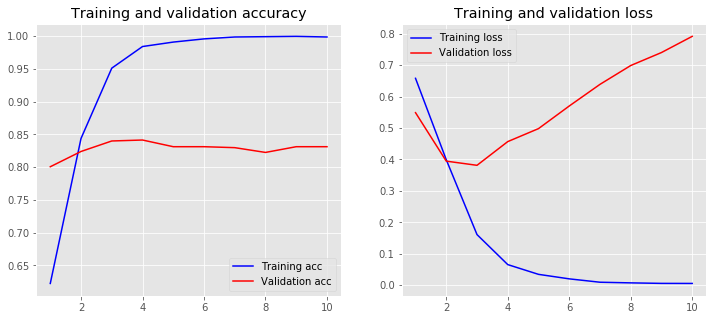

In [11]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
util.plot_history(history)

In [12]:
#dang this is very very clearly overfitted
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [14]:
model.save('my_model.h5')